In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import dask 
from pyclustering.cluster.xmeans import xmeans, kmeans_plusplus_initializer
import hdbscan
import time
import seaborn as sns
import dask.dataframe as dd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from collections import defaultdict
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import LocalOutlierFactor
import skfuzzy as fuzz
from scipy.fftpack import fft
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from itertools import product
from dask import delayed
from dask.distributed import Client, progress


In [3]:
# Read the parquet file
filtered_transactions = pd.read_parquet('filtered_transactions.parquet')
# Display the first few rows
print(filtered_transactions.head())


                                         CUST_CUSTNO  VALUEDATE  \
0  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-05   
1  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-06   
2  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-10   
3  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-11   
4  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-13   

   TOTAL_RECEIVED  TOTAL_SENT  TOTAL_ABSOLUTE  
0          1500.0      -300.0          1800.0  
1             0.0     -1000.0          1000.0  
2         12717.6     -2063.0         14780.6  
3             0.0     -3439.0          3439.0  
4             0.0     -2500.0          2500.0  


In [4]:
# Take the absolute value of the columns before applying log transformation
filtered_transactions['TOTAL_SENT'] = filtered_transactions['TOTAL_SENT'].abs()
filtered_transactions['TOTAL_RECEIVED'] = filtered_transactions['TOTAL_RECEIVED'].abs()

# Apply the log transformation
filtered_transactions['log_TOTAL_SENT'] = np.log1p(filtered_transactions['TOTAL_SENT'])
filtered_transactions['log_TOTAL_RECEIVED'] = np.log1p(filtered_transactions['TOTAL_RECEIVED'])



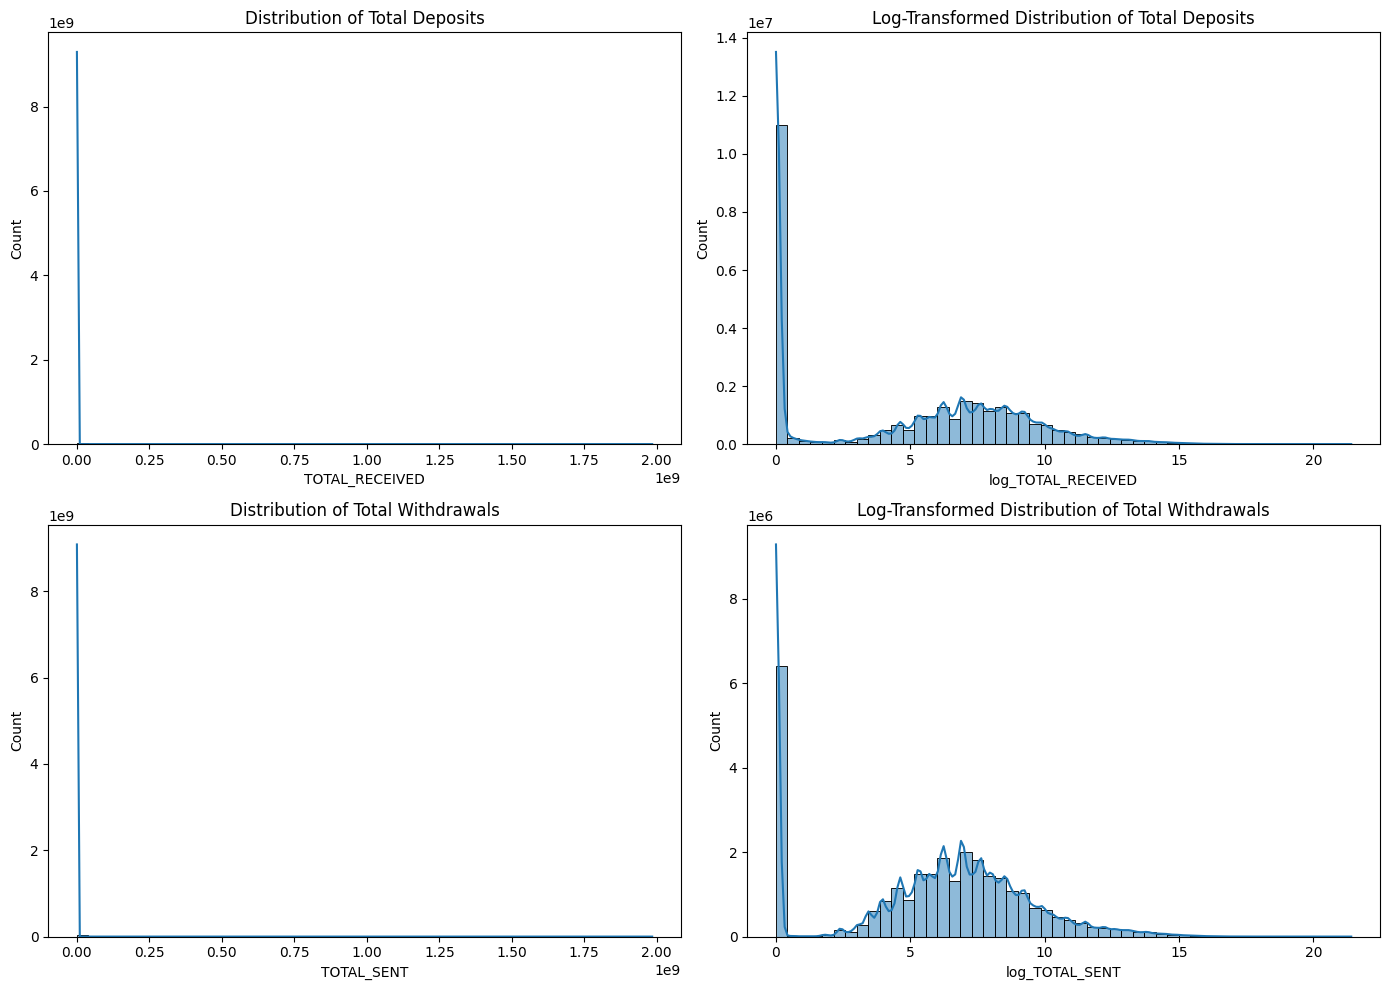

In [10]:
# Plot the distributions before and after log transformation
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(filtered_transactions['TOTAL_RECEIVED'], bins=50, kde=True, ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Total Deposits')

sns.histplot(filtered_transactions['log_TOTAL_RECEIVED'], bins=50, kde=True, ax=ax[0, 1])
ax[0, 1].set_title('Log-Transformed Distribution of Total Deposits')

sns.histplot(filtered_transactions['TOTAL_SENT'].abs(), bins=50, kde=True, ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Total Withdrawals')

sns.histplot(filtered_transactions['log_TOTAL_SENT'], bins=50, kde=True, ax=ax[1, 1])
ax[1, 1].set_title('Log-Transformed Distribution of Total Withdrawals')

plt.tight_layout()
plt.show()

In [11]:
anomalies=filtered_transactions.copy()

In [12]:
# Rule-based anomalies
rule_15_anomalies = anomalies[
    (anomalies['TOTAL_RECEIVED'] >= 6000000) &
    (anomalies['TOTAL_SENT'].abs() >= 0.95 * anomalies['TOTAL_RECEIVED'])
]
rule_15_anomalies

,CUST_CUSTNO,VALUEDATE,TOTAL_RECEIVED,TOTAL_SENT,TOTAL_ABSOLUTE,log_TOTAL_SENT,log_TOTAL_RECEIVED
702,0002270df70734f8d04c42004d9995e8b97fe3ff9de575...,2023-11-08,6925150.00,6924000.00,13849150.00,15.750504,15.750670
2170,0004abe134ca2b7af66656ecc3232a24a1167e71aa2bd9...,2023-09-23,8000493.15,8000008.22,16000501.37,15.894953,15.895014
4095,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-22,10469355.99,10051700.46,20521056.45,16.123252,16.163963
4102,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-29,7179280.10,7513252.10,14692532.20,15.832179,15.786710
4142,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-10-10,7609562.68,9133854.50,16743417.18,16.027498,15.844916
...,...,...,...,...,...,...,...
28979127,ffdc5cead1c3798acfabfbc6eb7646e4b5d9e540f35ee3...,2023-09-30,12854001.29,12512900.03,25366901.32,16.342271,16.369166
28985946,ffe85c70096ca3b80d36d42577c9c12eb0ed1ad9508851...,2023-09-19,6012400.00,6012400.00,12024800.00,15.609335,15.609335
28988045,ffecb0aaab47e4d92ac4176cdee0c3d9dd4617216035c8...,2023-08-31,6242683.78,6231263.79,12473947.57,15.645090,15.646921
28988705,ffed5808f5090ac8cfa75f590ff0874f5787cde1784b40...,2023-12-29,9738344.66,11274259.32,21012603.98,16.238033,16.091582


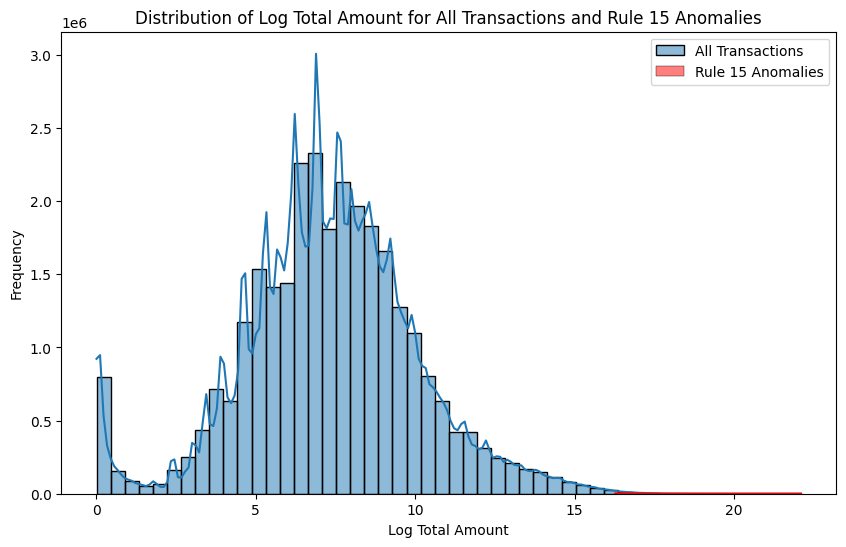

In [14]:
# Calculate the log of total amounts for all transactions
anomalies['log_total_amount'] = np.log1p(anomalies['TOTAL_RECEIVED'] + anomalies['TOTAL_SENT'].abs())

# Calculate the log of total amounts for rule_15 anomalies
rule_15_anomalies['log_total_amount'] = np.log1p(rule_15_anomalies['TOTAL_RECEIVED'] + rule_15_anomalies['TOTAL_SENT'].abs())

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(anomalies['log_total_amount'], bins=50, kde=True, label='All Transactions')
sns.histplot(rule_15_anomalies['log_total_amount'], bins=50, kde=True, color='red', label='Rule 15 Anomalies')
plt.title('Distribution of Log Total Amount for All Transactions and Rule 15 Anomalies')
plt.xlabel('Log Total Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [5]:
# Prepare the data for clustering
features = filtered_transactions[['log_TOTAL_RECEIVED', 'log_TOTAL_SENT' ]].values

In [6]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [8]:
print(filtered_transactions.describe())  # Get summary statistics


                        VALUEDATE  TOTAL_RECEIVED    TOTAL_SENT  \
count                    28997435    2.899744e+07  2.899744e+07   
mean   2023-11-03 16:09:34.118203    4.937165e+04  4.951421e+04   
min           2023-08-01 00:00:00    0.000000e+00  0.000000e+00   
25%           2023-09-20 00:00:00    0.000000e+00  3.000000e+01   
50%           2023-11-06 00:00:00    2.390000e+02  5.000000e+02   
75%           2023-12-19 00:00:00    3.250000e+03  3.300000e+03   
max           2024-01-30 00:00:00    1.984136e+09  1.984135e+09   
std                           NaN    1.433748e+06  1.469107e+06   

       TOTAL_ABSOLUTE  log_TOTAL_SENT  log_TOTAL_RECEIVED  
count    2.899744e+07    2.899744e+07        2.899744e+07  
mean     9.888586e+04    5.652948e+00        4.696080e+00  
min      1.000000e-02    0.000000e+00        0.000000e+00  
25%      3.000000e+02    3.433987e+00        0.000000e+00  
50%      1.500000e+03    6.216606e+00        5.480639e+00  
75%      8.000000e+03    8.101981e+0

In [9]:
features_scaled.shape

(28997435, 2)

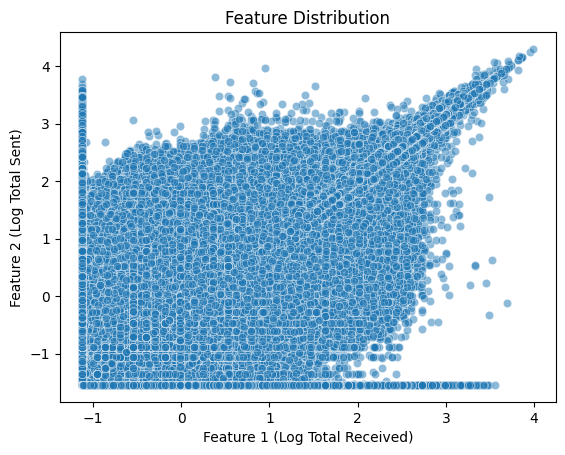

In [13]:
sns.scatterplot(x=features_scaled[:, 0], y=features_scaled[:, 1], alpha=0.5)
plt.title("Feature Distribution")
plt.xlabel("Feature 1 (Log Total Received)")
plt.ylabel("Feature 2 (Log Total Sent)")
plt.show()

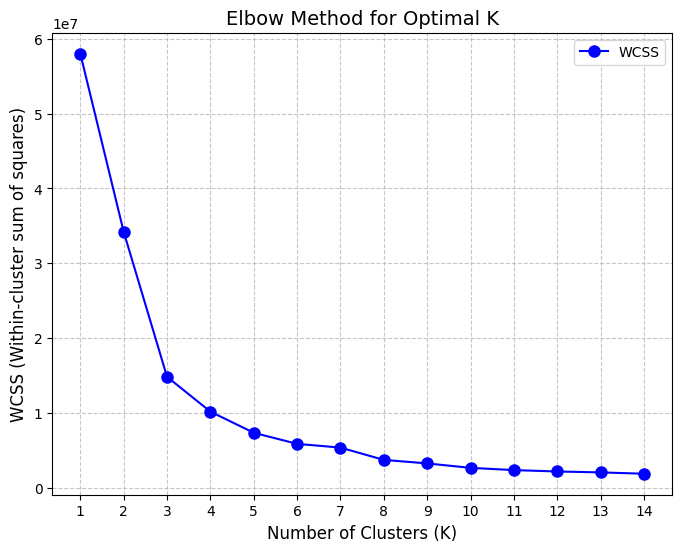

In [14]:
# 10. Apply K-means clustering with different K values and compute WCSS (within-cluster sum of squares)
wcss = []
K_range = range(1, 15)  # We will try K from 1 to 15

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ gives the WCSS for the clusters

# 11. Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(K_range, wcss, 'bo-', markersize=8, marker='o', color='b', label='WCSS')
plt.title('Elbow Method for Optimal K', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('WCSS (Within-cluster sum of squares)', fontsize=12)
plt.xticks(K_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


In [15]:
# Set the number of clusters
n_clusters = 3


In [16]:
# 11. Apply K-Means Clustering (We will use 3 clusters based on Elbow method)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(features_scaled)

In [19]:
# Add the K-means labels to the filtered transactions dataframe
new_transactions = filtered_transactions.copy()
new_transactions['kmeans_label'] = kmeans_labels
new_transactions

,CUST_CUSTNO,VALUEDATE,TOTAL_RECEIVED,TOTAL_SENT,TOTAL_ABSOLUTE,log_TOTAL_SENT,log_TOTAL_RECEIVED,kmeans_label
0,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-05,1500.00,300.00,1800.00,5.707110,7.313887,2
1,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-06,0.00,1000.00,1000.00,6.908755,0.000000,1
2,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-10,12717.60,2063.00,14780.60,7.632401,9.450821,2
3,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-11,0.00,3439.00,3439.00,8.143227,0.000000,1
4,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-13,0.00,2500.00,2500.00,7.824446,0.000000,1
...,...,...,...,...,...,...,...,...
28997430,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2023-12-03,0.00,10000.00,10000.00,9.210440,0.000000,1
28997431,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2023-12-31,0.46,0.00,0.46,0.000000,0.378436,0
28997432,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2024-01-06,142350.14,130000.00,272350.14,11.775297,11.866052,2
28997433,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2024-01-10,142429.56,242351.56,384781.12,12.398149,11.866610,2


In [20]:
total_samples = len(new_transactions)
cluster_counts = new_transactions['kmeans_label'].value_counts()
print("Cluster Counts and Percentage of Samples:")
for cluster_label, count in cluster_counts.items():
  percentage = (count / total_samples) * 100
  print(f"Cluster {cluster_label}: Count = {count}, Percentage = {percentage:.2f}%")


Cluster Counts and Percentage of Samples:
Cluster 1: Count = 11140851, Percentage = 38.42%
Cluster 2: Count = 10787423, Percentage = 37.20%
Cluster 0: Count = 7069161, Percentage = 24.38%


In [21]:
# Step 5: Compute distance of each point to its cluster centroid
distances = np.linalg.norm(features_scaled - kmeans.cluster_centers_[new_transactions['kmeans_label']], axis=1)

# Compute statistics on the distances
mean_distance = np.mean(distances)
std_distance = np.std(distances)
min_distance = np.min(distances)
max_distance = np.max(distances)
# Print statistics
print(f"Mean Distance: {mean_distance:.4f}")
print(f"Standard Deviation: {std_distance:.4f}")
print(f"Min Distance: {min_distance:.4f}")
print(f"Max Distance: {max_distance:.4f}")


Mean Distance: 0.5822
Standard Deviation: 0.4156
Min Distance: 0.0004
Max Distance: 4.6906


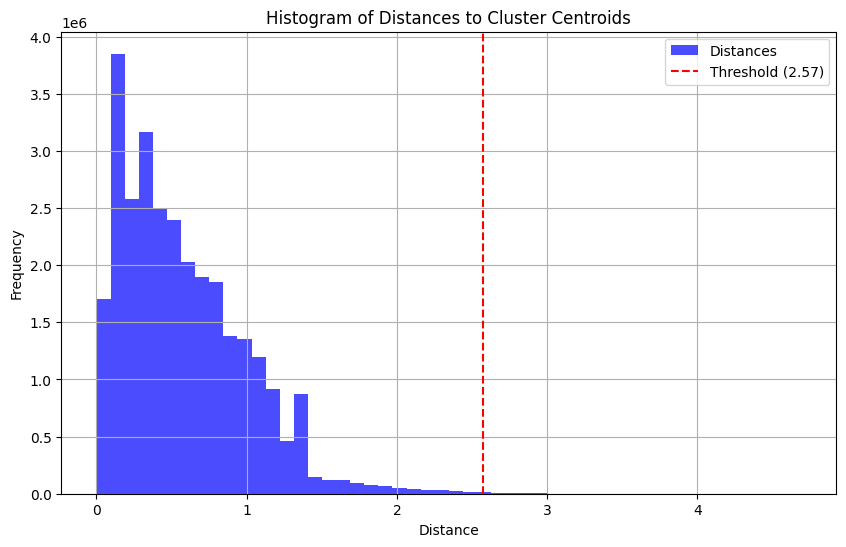

In [55]:
# Step 5: Compute distance of each point to its cluster centroid
distances = np.linalg.norm(features_scaled - kmeans.cluster_centers_[new_transactions['kmeans_label']], axis=1)

# Step 6: Set an anomaly threshold (e.g., top 5% of distances)
threshold = 2.57
new_transactions['anomaly_kmeans'] = distances > threshold  # True if it's an anomaly

# Plotting the distances and threshold
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=50, alpha=0.7, color='blue', label='Distances')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')

plt.title('Histogram of Distances to Cluster Centroids')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
# Step 7: Add scoring based on distances (you can directly use the distance as the score)
new_transactions['anomaly_score_kmeans'] = distances

# Display the dataframe with the anomaly flags and scores
print(new_transactions.head())

                                         CUST_CUSTNO  VALUEDATE  \
0  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-05   
1  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-06   
2  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-10   
3  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-11   
4  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-13   

   TOTAL_RECEIVED  TOTAL_SENT  TOTAL_ABSOLUTE  log_TOTAL_SENT  \
0          1500.0       300.0          1800.0        5.707110   
1             0.0      1000.0          1000.0        6.908755   
2         12717.6      2063.0         14780.6        7.632401   
3             0.0      3439.0          3439.0        8.143227   
4             0.0      2500.0          2500.0        7.824446   

   log_TOTAL_RECEIVED  kmeans_label  anomaly_kmeans  anomaly_score_kmeans  \
0            7.313887             2           False              0.800492   
1            0.000000             1           False 

In [57]:
# Rule-based anomalies
rule_15_anomalies = new_transactions[
    (new_transactions['TOTAL_RECEIVED'] >= 6000000) &
    (new_transactions['TOTAL_SENT'].abs() >= 0.95 * new_transactions['TOTAL_RECEIVED'])
]
rule_15_anomalies

,CUST_CUSTNO,VALUEDATE,TOTAL_RECEIVED,TOTAL_SENT,TOTAL_ABSOLUTE,log_TOTAL_SENT,log_TOTAL_RECEIVED,kmeans_label,anomaly_kmeans,anomaly_score_kmeans,true_anomaly,predicted_anomaly
702,0002270df70734f8d04c42004d9995e8b97fe3ff9de575...,2023-11-08,6925150.00,6924000.00,13849150.00,15.750504,15.750670,2,True,2.638273,True,1
2170,0004abe134ca2b7af66656ecc3232a24a1167e71aa2bd9...,2023-09-23,8000493.15,8000008.22,16000501.37,15.894953,15.895014,2,True,2.690653,True,1
4095,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-22,10469355.99,10051700.46,20521056.45,16.123252,16.163963,2,True,2.779822,True,1
4102,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-29,7179280.10,7513252.10,14692532.20,15.832179,15.786710,2,True,2.660788,True,1
4142,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-10-10,7609562.68,9133854.50,16743417.18,16.027498,15.844916,2,True,2.710417,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...
28979127,ffdc5cead1c3798acfabfbc6eb7646e4b5d9e540f35ee3...,2023-09-30,12854001.29,12512900.03,25366901.32,16.342271,16.369166,2,True,2.857106,True,1
28985946,ffe85c70096ca3b80d36d42577c9c12eb0ed1ad9508851...,2023-09-19,6012400.00,6012400.00,12024800.00,15.609335,15.609335,2,True,2.587040,True,1
28988045,ffecb0aaab47e4d92ac4176cdee0c3d9dd4617216035c8...,2023-08-31,6242683.78,6231263.79,12473947.57,15.645090,15.646921,2,True,2.600295,True,1
28988705,ffed5808f5090ac8cfa75f590ff0874f5787cde1784b40...,2023-12-29,9738344.66,11274259.32,21012603.98,16.238033,16.091582,2,True,2.792347,True,1


In [58]:
# Step 8: Count the detected anomalies
print(new_transactions['anomaly_kmeans'].value_counts())

anomaly_kmeans
False    28968295
True        29140
Name: count, dtype: int64


# Kmeans Metrics

In [59]:
# Step 1: Create ground truth labels (1 if in Rule 15 anomalies, else 0)
new_transactions['true_anomaly'] = new_transactions.index.isin(rule_15_anomalies.index)

# Step 2: Get K-Means anomaly labels (1 for anomaly, 0 for normal)
new_transactions['predicted_anomaly'] = new_transactions['anomaly_kmeans'].astype(int)

# Step 3: Compute Precision and Recall
precision = precision_score(new_transactions['true_anomaly'], new_transactions['predicted_anomaly'])
recall = recall_score(new_transactions['true_anomaly'], new_transactions['predicted_anomaly'])

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Precision: 0.7111
Recall: 1.0000


In [101]:
new_transactions.to_parquet('Kmeans_with_anomalies.parquet')


In [63]:
# Set the number of clusters
n_clusters = 3

In [64]:
# Apply Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    features_scaled.T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None)

In [66]:
# Assign clusters to each transaction based on the highest membership
cluster_labels = np.argmax(u, axis=0)

In [71]:
# Add the cluster labels to the DataFrame
cmeans_transactions = filtered_transactions.copy()
cmeans_transactions['cluster'] = cluster_labels
cmeans_transactions

,CUST_CUSTNO,VALUEDATE,TOTAL_RECEIVED,TOTAL_SENT,TOTAL_ABSOLUTE,log_TOTAL_SENT,log_TOTAL_RECEIVED,cluster
0,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-05,1500.00,300.00,1800.00,5.707110,7.313887,2
1,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-06,0.00,1000.00,1000.00,6.908755,0.000000,1
2,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-10,12717.60,2063.00,14780.60,7.632401,9.450821,2
3,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-11,0.00,3439.00,3439.00,8.143227,0.000000,1
4,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-13,0.00,2500.00,2500.00,7.824446,0.000000,1
...,...,...,...,...,...,...,...,...
28997430,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2023-12-03,0.00,10000.00,10000.00,9.210440,0.000000,1
28997431,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2023-12-31,0.46,0.00,0.46,0.000000,0.378436,0
28997432,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2024-01-06,142350.14,130000.00,272350.14,11.775297,11.866052,2
28997433,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2024-01-10,142429.56,242351.56,384781.12,12.398149,11.866610,2


In [73]:
# Count the number of transactions in each cluster
cmeans_transactions['cluster'].value_counts()

cluster
1    11432820
2    10535353
0     7029262
Name: count, dtype: int64

In [74]:
# Calculate suspicion scores based on distance from the cluster centroid
suspicion_scores = np.min(d, axis=0)
cmeans_transactions['suspicion_score'] = suspicion_scores

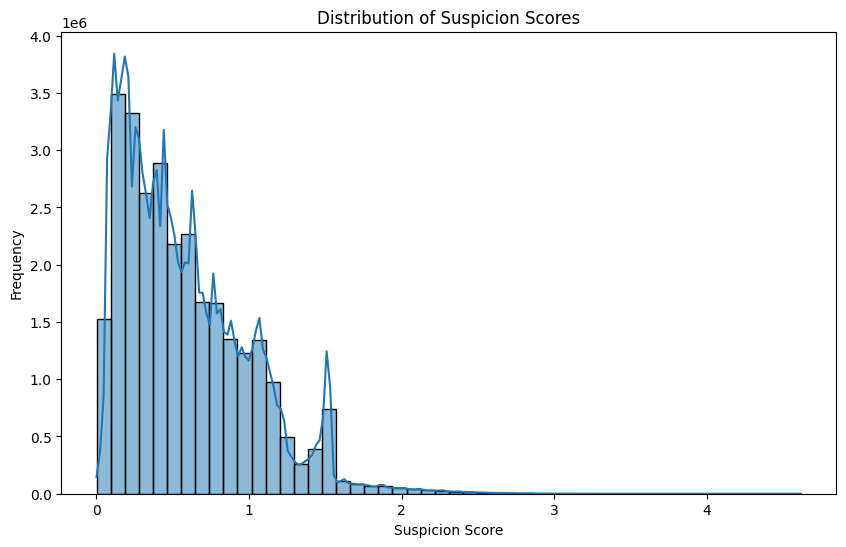

Mean: 0.5847
Standard Deviation: 0.4204
Skewness: 1.0725
Kurtosis: 1.3021


In [76]:
# Plot the distribution of suspicion scores
plt.figure(figsize=(10, 6))
sns.histplot(cmeans_transactions['suspicion_score'], bins=50, kde=True)
plt.title('Distribution of Suspicion Scores')
plt.xlabel('Suspicion Score')
plt.ylabel('Frequency')
plt.show()
mean_score = cmeans_transactions['suspicion_score'].mean()
std_score = cmeans_transactions['suspicion_score'].std()
skewness_score = cmeans_transactions['suspicion_score'].skew()
kurtosis_score = cmeans_transactions['suspicion_score'].kurtosis()

print(f"Mean: {mean_score:.4f}")
print(f"Standard Deviation: {std_score:.4f}")
print(f"Skewness: {skewness_score:.4f}")
print(f"Kurtosis: {kurtosis_score:.4f}")


Text(0, 0.5, 'Density')

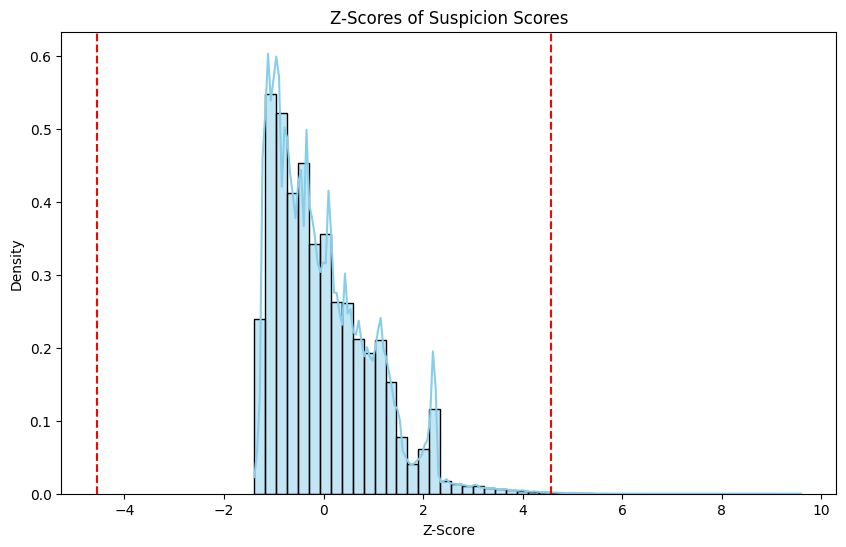

In [105]:
# Calculate the Z-scores for each suspicion score
cmeans_transactions['z_score'] = (cmeans_transactions['suspicion_score'] - mean_score) / std_score

# Set the Z-score threshold for anomaly detection
z_score_threshold = 4.56 # You can adjust this to 3 or other values based on your preference

# Flag the anomalies based on the Z-score threshold
cmeans_transactions['is_anomaly'] = cmeans_transactions['z_score'].apply(lambda x: abs(x) > z_score_threshold)

# Plotting Z-scores for anomaly detection
plt.figure(figsize=(10, 6))
sns.histplot(cmeans_transactions['z_score'], bins=50, kde=True, color='skyblue', stat="density")
plt.axvline(z_score_threshold, color='red', linestyle='--', label=f'Z-Score Threshold: {z_score_threshold}')
plt.axvline(-z_score_threshold, color='red', linestyle='--')
plt.title('Z-Scores of Suspicion Scores')
plt.xlabel('Z-Score')
plt.ylabel('Density')

In [106]:
# Rule-based anomalies
rule_15_anomalies = cmeans_transactions[
    (cmeans_transactions['TOTAL_RECEIVED'] >= 6000000) &
    (cmeans_transactions['TOTAL_SENT'].abs() >= 0.95 * cmeans_transactions['TOTAL_RECEIVED'])
]
rule_15_anomalies

,CUST_CUSTNO,VALUEDATE,TOTAL_RECEIVED,TOTAL_SENT,TOTAL_ABSOLUTE,log_TOTAL_SENT,log_TOTAL_RECEIVED,cluster,suspicion_score,z_score,is_anomaly,rule_15_label
702,0002270df70734f8d04c42004d9995e8b97fe3ff9de575...,2023-11-08,6925150.00,6924000.00,13849150.00,15.750504,15.750670,2,2.563786,4.707974,True,1
2170,0004abe134ca2b7af66656ecc3232a24a1167e71aa2bd9...,2023-09-23,8000493.15,8000008.22,16000501.37,15.894953,15.895014,2,2.616167,4.832582,True,1
4095,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-22,10469355.99,10051700.46,20521056.45,16.123252,16.163963,2,2.705369,5.044784,True,1
4102,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-29,7179280.10,7513252.10,14692532.20,15.832179,15.786710,2,2.586265,4.761449,True,1
4142,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-10-10,7609562.68,9133854.50,16743417.18,16.027498,15.844916,2,2.635792,4.879268,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...
28979127,ffdc5cead1c3798acfabfbc6eb7646e4b5d9e540f35ee3...,2023-09-30,12854001.29,12512900.03,25366901.32,16.342271,16.369166,2,2.782643,5.228609,True,1
28985946,ffe85c70096ca3b80d36d42577c9c12eb0ed1ad9508851...,2023-09-19,6012400.00,6012400.00,12024800.00,15.609335,15.609335,2,2.512552,4.586094,True,1
28988045,ffecb0aaab47e4d92ac4176cdee0c3d9dd4617216035c8...,2023-08-31,6242683.78,6231263.79,12473947.57,15.645090,15.646921,2,2.525809,4.617631,True,1
28988705,ffed5808f5090ac8cfa75f590ff0874f5787cde1784b40...,2023-12-29,9738344.66,11274259.32,21012603.98,16.238033,16.091582,2,2.717753,5.074244,True,1


# Fuzzy Cmeans metrics

In [107]:
# Adding the Rule 15 label for precision, recall, and FPR calculation
cmeans_transactions['rule_15_label'] = cmeans_transactions.index.isin(rule_15_anomalies.index).astype(int)  # 1 = Fraudulent, 0 = Normal

# Compute precision, recall, and confusion matrix
precision = precision_score(cmeans_transactions['rule_15_label'], cmeans_transactions['is_anomaly'])
recall = recall_score(cmeans_transactions['rule_15_label'], cmeans_transactions['is_anomaly'])

# Compute confusion matrix to extract FP and TN
tn, fp, fn, tp = confusion_matrix(cmeans_transactions['rule_15_label'], cmeans_transactions['is_anomaly']).ravel()

# Compute False Positive Rate (FPR)
fpr = fp / (fp + tn)

# Print the evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall (True Positive Rate): {recall:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")

Precision: 0.7206
Recall (True Positive Rate): 1.0000
False Positive Rate (FPR): 0.0003


In [108]:
cmeans_transactions.to_parquet('cmeans_with_anomalies.parquet')


In [7]:
# Use a subset for fast tuning (e.g. 1 million points)
sample_size = 1_000_000
sample_idx = np.random.choice(len(features), sample_size, replace=False)
sample_data = features[sample_idx]

# Optional: Scale the data (recommended)
scaler = StandardScaler()
sample_data_scaled = scaler.fit_transform(sample_data)


In [8]:

# Parameter grid
min_cluster_sizes = [300, 500, 800]
min_samples_list = [30, 50, 80]

# Try different combinations
results = []

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_list:
        print(f"Testing min_cluster_size={min_cluster_size}, min_samples={min_samples}...")
        start = time.time()
        
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            core_dist_n_jobs=-1
        )
        labels = clusterer.fit_predict(sample_data_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_points = np.sum(labels == -1)
        runtime = time.time() - start
        
        results.append({
            'min_cluster_size': min_cluster_size,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'noise_points': noise_points,
            'runtime_sec': round(runtime, 2)
        })

# Display summary
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='runtime_sec'))


Testing min_cluster_size=300, min_samples=30...
Testing min_cluster_size=300, min_samples=50...
Testing min_cluster_size=300, min_samples=80...
Testing min_cluster_size=500, min_samples=30...
Testing min_cluster_size=500, min_samples=50...
Testing min_cluster_size=500, min_samples=80...
Testing min_cluster_size=800, min_samples=30...
Testing min_cluster_size=800, min_samples=50...
Testing min_cluster_size=800, min_samples=80...
   min_cluster_size  min_samples  n_clusters  noise_points  runtime_sec
7               800           50         249        408880        16.79
2               300           80         568        379667        17.72
5               500           80         369        397761        17.95
4               500           50         393        392205        18.12
8               800           80         246        407788        18.28
6               800           30         264        388745        18.49
3               500           30         394        370000      

In [9]:
# Define a scoring function (or sort by n_clusters descending, noise ascending)
results_df['score'] = results_df['n_clusters'] - (results_df['noise_points'] / sample_size)

# Choose the best row (highest score)
best_params = results_df.sort_values(by='score', ascending=False).iloc[0]
print("Best HDBSCAN config:", best_params)

# Extract parameters
best_min_cluster_size = int(best_params['min_cluster_size'])
best_min_samples = int(best_params['min_samples'])


Best HDBSCAN config: min_cluster_size       300.000000
min_samples             30.000000
n_clusters             622.000000
noise_points        351288.000000
runtime_sec             19.680000
score                  621.648712
Name: 0, dtype: float64


In [10]:
# Scale the full dataset using the same scaler
features_scaled_full = scaler.transform(features)

# Run HDBSCAN on the full dataset
best_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=best_min_cluster_size,
    min_samples=best_min_samples,
    core_dist_n_jobs=-1
)

full_labels = best_clusterer.fit_predict(features_scaled_full)



In [11]:
# Create a new copy of the original filtered data
clustered_transactions = filtered_transactions.copy()

# Add the HDBSCAN cluster labels
clustered_transactions['HDBSCAN_cluster'] = full_labels
clustered_transactions

,CUST_CUSTNO,VALUEDATE,TOTAL_RECEIVED,TOTAL_SENT,TOTAL_ABSOLUTE,log_TOTAL_SENT,log_TOTAL_RECEIVED,HDBSCAN_cluster
0,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-05,1500.00,300.00,1800.00,5.707110,7.313887,10529
1,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-06,0.00,1000.00,1000.00,6.908755,0.000000,5834
2,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-10,12717.60,2063.00,14780.60,7.632401,9.450821,-1
3,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-11,0.00,3439.00,3439.00,8.143227,0.000000,916
4,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-13,0.00,2500.00,2500.00,7.824446,0.000000,4947
...,...,...,...,...,...,...,...,...
28997430,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2023-12-03,0.00,10000.00,10000.00,9.210440,0.000000,5616
28997431,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2023-12-31,0.46,0.00,0.46,0.000000,0.378436,3333
28997432,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2024-01-06,142350.14,130000.00,272350.14,11.775297,11.866052,9989
28997433,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2024-01-10,142429.56,242351.56,384781.12,12.398149,11.866610,-1


In [12]:
# Save as Parquet
clustered_transactions.to_parquet('clustered_transactions.parquet', index=False)


In [13]:
# Scale the full dataset using the same scaler
features_scaled_full = scaler.transform(features)

In [14]:
# Read the parquet file
clustered_transactions = pd.read_parquet('clustered_transactions.parquet')
# Display the first few rows
print(clustered_transactions.head())


                                         CUST_CUSTNO  VALUEDATE  \
0  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-05   
1  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-06   
2  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-10   
3  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-11   
4  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-13   

   TOTAL_RECEIVED  TOTAL_SENT  TOTAL_ABSOLUTE  log_TOTAL_SENT  \
0          1500.0       300.0          1800.0        5.707110   
1             0.0      1000.0          1000.0        6.908755   
2         12717.6      2063.0         14780.6        7.632401   
3             0.0      3439.0          3439.0        8.143227   
4             0.0      2500.0          2500.0        7.824446   

   log_TOTAL_RECEIVED  HDBSCAN_cluster  
0            7.313887            10529  
1            0.000000             5834  
2            9.450821               -1  
3            0.000000              916  
4

In [15]:
valid_mask = clustered_transactions['HDBSCAN_cluster'] != -1
valid_data = clustered_transactions[valid_mask]
valid_features = features_scaled_full[valid_mask]
labels = valid_data['HDBSCAN_cluster'].values

# Centroids
unique_clusters = np.unique(labels)
centroids = np.array([valid_features[labels == c].mean(axis=0) for c in unique_clusters])
label_to_centroid = dict(zip(unique_clusters, centroids))

# Distance calculation
distances = []
for i, row in enumerate(clustered_transactions.itertuples()):
    label = row.HDBSCAN_cluster
    if label == -1:
        distances.append(np.nan)
    else:
        centroid = label_to_centroid[label]
        point = features_scaled_full[i]
        dist = np.linalg.norm(point - centroid)
        distances.append(dist)

clustered_transactions['euclidean_distance_to_centroid'] = distances


In [16]:
distance_summary = clustered_transactions['euclidean_distance_to_centroid'].describe()
print(distance_summary)


count    2.188412e+07
mean     1.310950e-03
std      8.363625e-03
min      4.440892e-16
25%      5.165265e-12
50%      4.077147e-06
75%      1.429977e-04
max      8.156154e-01
Name: euclidean_distance_to_centroid, dtype: float64


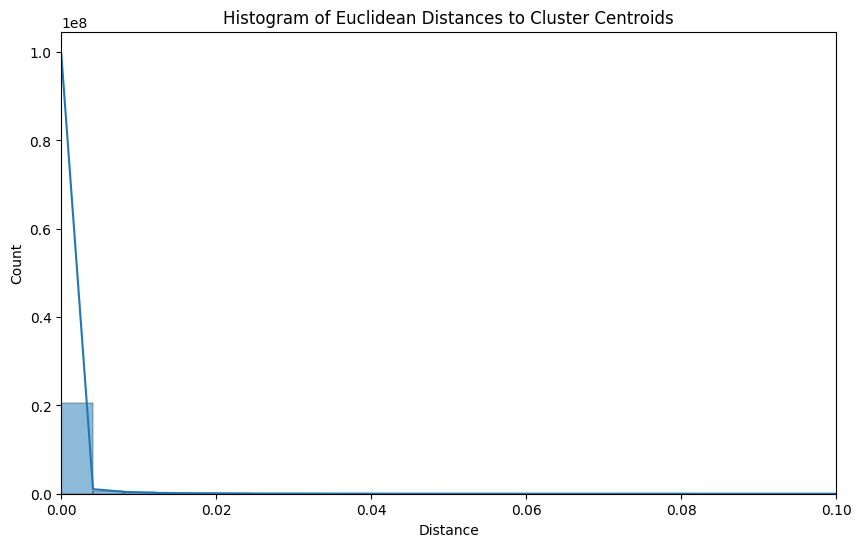

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(
    clustered_transactions['euclidean_distance_to_centroid'].dropna(),
    bins=200,
    kde=True
)
plt.title("Histogram of Euclidean Distances to Cluster Centroids")
plt.xlabel("Distance")
plt.ylabel("Count")
plt.xlim(0, 0.1)  # zoom into meaningful range (adjust if needed)
plt.show()

In [18]:
# Rule 15: customers receiving >= 6M and withdrawing >= 95% of that
rule15_anomalies = clustered_transactions[
    (clustered_transactions['TOTAL_RECEIVED'] >= 6000000) &
    (clustered_transactions['TOTAL_SENT'].abs() >= 0.95 * clustered_transactions['TOTAL_RECEIVED'])
]
rule15_ids = set(rule15_anomalies['CUST_CUSTNO'])
rule15_anomalies

,CUST_CUSTNO,VALUEDATE,TOTAL_RECEIVED,TOTAL_SENT,TOTAL_ABSOLUTE,log_TOTAL_SENT,log_TOTAL_RECEIVED,HDBSCAN_cluster,euclidean_distance_to_centroid
702,0002270df70734f8d04c42004d9995e8b97fe3ff9de575...,2023-11-08,6925150.00,6924000.00,13849150.00,15.750504,15.750670,9574,0.008138
2170,0004abe134ca2b7af66656ecc3232a24a1167e71aa2bd9...,2023-09-23,8000493.15,8000008.22,16000501.37,15.894953,15.895014,9549,0.000647
4095,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-22,10469355.99,10051700.46,20521056.45,16.123252,16.163963,-1,NaN
4102,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-29,7179280.10,7513252.10,14692532.20,15.832179,15.786710,-1,NaN
4142,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-10-10,7609562.68,9133854.50,16743417.18,16.027498,15.844916,-1,NaN
...,...,...,...,...,...,...,...,...,...
28979127,ffdc5cead1c3798acfabfbc6eb7646e4b5d9e540f35ee3...,2023-09-30,12854001.29,12512900.03,25366901.32,16.342271,16.369166,-1,NaN
28985946,ffe85c70096ca3b80d36d42577c9c12eb0ed1ad9508851...,2023-09-19,6012400.00,6012400.00,12024800.00,15.609335,15.609335,9576,0.007833
28988045,ffecb0aaab47e4d92ac4176cdee0c3d9dd4617216035c8...,2023-08-31,6242683.78,6231263.79,12473947.57,15.645090,15.646921,9576,0.005426
28988705,ffed5808f5090ac8cfa75f590ff0874f5787cde1784b40...,2023-12-29,9738344.66,11274259.32,21012603.98,16.238033,16.091582,-1,NaN


In [ ]:
# Tune LOF with multiple n_neighbors
lof_results = []

for k in [10, 20, 30, 50, 70, 100]:
    lof = LocalOutlierFactor(n_neighbors=k, novelty=False, n_jobs=-1)
    preds = lof.fit_predict(features_scaled_full)
    scores = -lof.negative_outlier_factor_
    
    clustered_transactions['LOF_score'] = scores
    threshold = clustered_transactions['LOF_score'].quantile(0.995)
    lof_anomalies = clustered_transactions[clustered_transactions['LOF_score'] > threshold]
    lof_ids = set(lof_anomalies['CUST_CUSTNO'])

    intersection = rule15_ids.intersection(lof_ids)
    precision = len(intersection) / len(lof_ids) if lof_ids else 0
    recall = len(intersection) / len(rule15_ids) if rule15_ids else 0
    
    lof_results.append({
        'n_neighbors': k,
        'precision': precision,
        'recall': recall,
        'overlap': len(intersection),
        'lof_anomalies': len(lof_ids)
    })

lof_df = pd.DataFrame(lof_results)


Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x14d1eb82c0e0>
Traceback (most recent call last):
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Compiler/gcccore/python/3.11.5/lib/python3.11/weakref.py", line 105, in remove
KeyboardInterrupt: 
Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
Traceback (most recent call last):
  File "/lustre06/project/6005082/malek/MALEK/lib/python3.11/site-packages/ipykernel/iostream.py", line 609, in flush
    if not evt.wait(self.flush_timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Compiler/gcccore/python/3.11.5/lib/python3.11/threading.py", line 622, in wait
    signaled = self._cond.wait(timeout)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Compiler/gcccore/python/3.11.5/lib/python3.11/threading.py", line 324, in wait
    gotit

In [ ]:
clustered_transactions['hybrid_anomaly'] = (
    (clustered_transactions['HDBSCAN_cluster'] == -1) |
    (clustered_transactions['LOF_score'] > clustered_transactions['LOF_score'].quantile(0.995))
)


In [8]:
# Keep a copy to assign labels later
xmeans_input = features_scaled.astype(np.float32)

In [13]:
import numpy as np
print(np.__version__)

1.24.4


In [14]:
import numpy as np
import warnings

# Monkey patch to fix pyclustering issue
if not hasattr(np, 'warnings'):
    np.warnings = warnings


In [15]:
from pyclustering.cluster.xmeans import xmeans, kmeans_plusplus_initializer
import numpy as np

best_result = None
best_config = None
best_num_clusters = 0

# Try different initializations and kmax values
for seed in range(3):  # Try 3 random initializations
    for kmax in [10, 20, 30, 40]:
        print(f"Trying seed={seed}, kmax={kmax}")
        np.random.seed(seed)
        
        # Initialize with KMeans++
        initial_centers = kmeans_plusplus_initializer(xmeans_input, 2, random_state=seed).initialize()
        
        # Create and process
        instance = xmeans(data=xmeans_input, initial_centers=initial_centers, kmax=kmax, ccore=True)
        instance.process()
        
        clusters = instance.get_clusters()
        if len(clusters) > best_num_clusters:
            best_result = instance
            best_config = {'seed': seed, 'kmax': kmax}
            best_num_clusters = len(clusters)


Trying seed=0, kmax=10
Trying seed=0, kmax=20
Trying seed=0, kmax=30
Trying seed=0, kmax=40
Trying seed=1, kmax=10
Trying seed=1, kmax=20
Trying seed=1, kmax=30
Trying seed=1, kmax=40
Trying seed=2, kmax=10
Trying seed=2, kmax=20
Trying seed=2, kmax=30
Trying seed=2, kmax=40


In [16]:
print(f" Best XMeans config: seed={best_config['seed']}, kmax={best_config['kmax']}, clusters={best_num_clusters}")

 Best XMeans config: seed=0, kmax=40, clusters=40


In [17]:
# Get best results
clusters = best_result.get_clusters()
centers = best_result.get_centers()
print(f" XMeans found {len(clusters)} clusters.") 



 XMeans found 40 clusters.


In [43]:
Xmeans_data=filtered_transactions.copy()

In [44]:
# Assign cluster labels
xmeans_labels = np.full(len(xmeans_input), -1)
for cluster_id, indices in enumerate(clusters):
    xmeans_labels[indices] = cluster_id
Xmeans_data['XMeans_cluster'] = xmeans_labels


In [45]:
# Show cluster distribution (percentage)
cluster_distribution = Xmeans_data['XMeans_cluster'].value_counts(normalize=True) * 100
print("Cluster distribution (percentage):")
print(cluster_distribution.sort_index())  # sort by cluster id


Cluster distribution (percentage):
XMeans_cluster
0     3.189741
1     3.504931
2     4.991604
3     2.024520
4     3.229641
5     1.140825
6     0.688933
7     0.864076
8     0.164832
9     4.816067
10    4.969540
11    1.842987
12    3.250281
13    2.159860
14    0.702203
15    2.204464
16    1.607732
17    1.774774
18    2.566227
19    2.538783
20    2.544929
21    2.837327
22    1.572829
23    0.491109
24    3.129549
25    0.701517
26    1.548575
27    1.168359
28    0.833025
29    3.582927
30    5.359153
31    2.010567
32    6.446270
33    6.611088
34    2.106607
35    1.342767
36    0.716298
37    0.205522
38    5.277881
39    3.281680
Name: proportion, dtype: float64


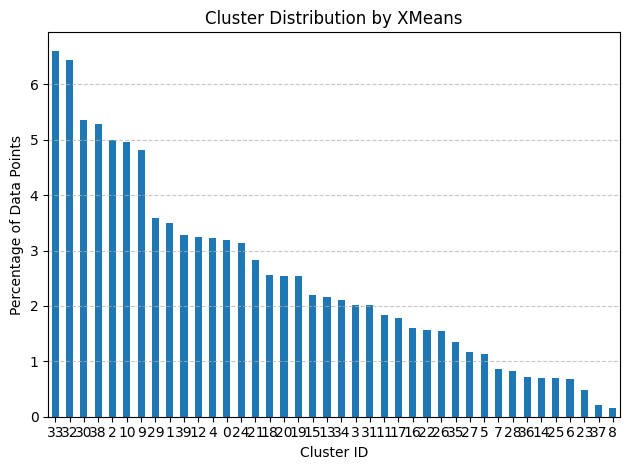

In [46]:
# Plot cluster distribution
cluster_distribution.plot(kind='bar')
plt.title('Cluster Distribution by XMeans')
plt.xlabel('Cluster ID')
plt.ylabel('Percentage of Data Points')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [47]:
# Compute Euclidean distance to the cluster centroid
distances_xmeans = []
for i, row in enumerate(xmeans_input):
    label = xmeans_labels[i]
    if label == -1:
        distances_xmeans.append(np.nan)
    else:
        centroid = centers[label]
        dist = np.linalg.norm(row - centroid)
        distances_xmeans.append(dist)

# Add distances to the DataFrame
Xmeans_data['xmeans_distance_to_centroid'] = distances_xmeans


In [48]:
Xmeans_data

,CUST_CUSTNO,VALUEDATE,TOTAL_RECEIVED,TOTAL_SENT,TOTAL_ABSOLUTE,log_TOTAL_SENT,log_TOTAL_RECEIVED,XMeans_cluster,xmeans_distance_to_centroid
0,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-05,1500.00,300.00,1800.00,5.707110,7.313887,30,0.300351
1,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-06,0.00,1000.00,1000.00,6.908755,0.000000,10,0.008959
2,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-10,12717.60,2063.00,14780.60,7.632401,9.450821,31,0.324583
3,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-11,0.00,3439.00,3439.00,8.143227,0.000000,12,0.118390
4,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-13,0.00,2500.00,2500.00,7.824446,0.000000,9,0.036332
...,...,...,...,...,...,...,...,...,...
28997430,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2023-12-03,0.00,10000.00,10000.00,9.210440,0.000000,13,0.132089
28997431,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2023-12-31,0.46,0.00,0.46,0.000000,0.378436,24,0.048862
28997432,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2024-01-06,142350.14,130000.00,272350.14,11.775297,11.866052,34,0.029223
28997433,fffff9df57f43b816e9ae9dd31699ccbeba7668c731de1...,2024-01-10,142429.56,242351.56,384781.12,12.398149,11.866610,34,0.178470


In [49]:
Xmeans_data.to_parquet('Xmeans_data.parquet', index=False)

In [77]:
# Read the parquet file
Xmeans_data = pd.read_parquet('Xmeans_data.parquet')
# Display the first few rows
print(Xmeans_data.head())


                                         CUST_CUSTNO  VALUEDATE  \
0  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-05   
1  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-06   
2  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-10   
3  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-11   
4  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608... 2023-08-13   

   TOTAL_RECEIVED  TOTAL_SENT  TOTAL_ABSOLUTE  log_TOTAL_SENT  \
0          1500.0       300.0          1800.0        5.707110   
1             0.0      1000.0          1000.0        6.908755   
2         12717.6      2063.0         14780.6        7.632401   
3             0.0      3439.0          3439.0        8.143227   
4             0.0      2500.0          2500.0        7.824446   

   log_TOTAL_RECEIVED  XMeans_cluster  xmeans_distance_to_centroid  
0            7.313887              30                     0.300351  
1            0.000000              10                     0.008959  

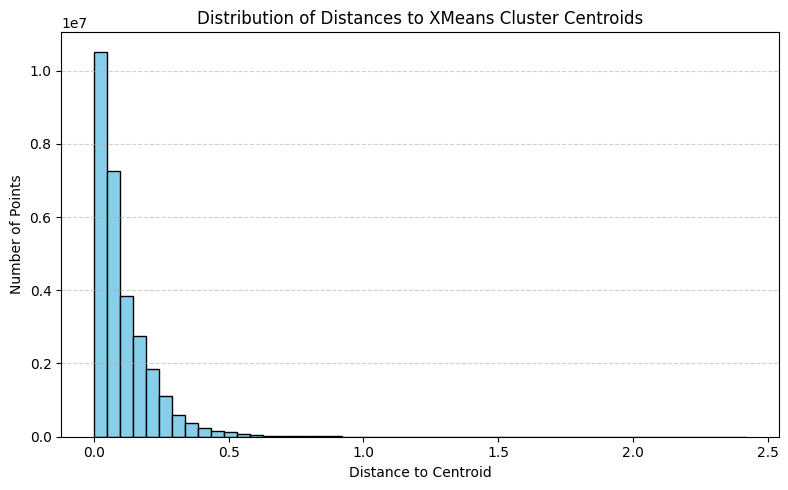

Summary of distances to cluster centroids:
count    2.899744e+07
mean     1.060920e-01
std      1.087818e-01
min      7.739325e-05
25%      3.190775e-02
50%      7.194376e-02
75%      1.477175e-01
max      2.419622e+00
Name: xmeans_distance_to_centroid, dtype: float64


In [78]:
# Histogram of distances
plt.figure(figsize=(8, 5))
plt.hist(Xmeans_data['xmeans_distance_to_centroid'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Distances to XMeans Cluster Centroids')
plt.xlabel('Distance to Centroid')
plt.ylabel('Number of Points')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Summary statistics of distances
distance_summary = Xmeans_data['xmeans_distance_to_centroid'].describe()
print("Summary of distances to cluster centroids:")
print(distance_summary)


In [79]:
# Rule 15: customers receiving >= 6M and withdrawing >= 95% of that
rule15_anomalies = Xmeans_data[
    (Xmeans_data['TOTAL_RECEIVED'] >= 6000000) &
    (Xmeans_data['TOTAL_SENT'].abs() >= 0.95 * Xmeans_data['TOTAL_RECEIVED'])
]
rule15_anomalies


,CUST_CUSTNO,VALUEDATE,TOTAL_RECEIVED,TOTAL_SENT,TOTAL_ABSOLUTE,log_TOTAL_SENT,log_TOTAL_RECEIVED,XMeans_cluster,xmeans_distance_to_centroid
702,0002270df70734f8d04c42004d9995e8b97fe3ff9de575...,2023-11-08,6925150.00,6924000.00,13849150.00,15.750504,15.750670,37,0.007579
2170,0004abe134ca2b7af66656ecc3232a24a1167e71aa2bd9...,2023-09-23,8000493.15,8000008.22,16000501.37,15.894953,15.895014,37,0.059263
4095,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-22,10469355.99,10051700.46,20521056.45,16.123252,16.163963,37,0.148752
4102,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-29,7179280.10,7513252.10,14692532.20,15.832179,15.786710,37,0.029638
4142,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-10-10,7609562.68,9133854.50,16743417.18,16.027498,15.844916,37,0.083893
...,...,...,...,...,...,...,...,...,...
28979127,ffdc5cead1c3798acfabfbc6eb7646e4b5d9e540f35ee3...,2023-09-30,12854001.29,12512900.03,25366901.32,16.342271,16.369166,37,0.225794
28985946,ffe85c70096ca3b80d36d42577c9c12eb0ed1ad9508851...,2023-09-19,6012400.00,6012400.00,12024800.00,15.609335,15.609335,37,0.044573
28988045,ffecb0aaab47e4d92ac4176cdee0c3d9dd4617216035c8...,2023-08-31,6242683.78,6231263.79,12473947.57,15.645090,15.646921,37,0.031405
28988705,ffed5808f5090ac8cfa75f590ff0874f5787cde1784b40...,2023-12-29,9738344.66,11274259.32,21012603.98,16.238033,16.091582,37,0.162228


In [80]:
rule15_anomalies['XMeans_cluster'].unique()

array([37])

In [81]:
# Group by cluster and calculate min & max distance for each cluster
cluster_distance_summary = Xmeans_data.groupby('XMeans_cluster')['xmeans_distance_to_centroid'].agg(['min', 'max'])
# Display the results
print("Summary of distances from centroid for each cluster:")
print(cluster_distance_summary)


Summary of distances from centroid for each cluster:
                     min       max
XMeans_cluster                    
0               0.000892  0.593878
1               0.001124  0.576518
2               0.000219  0.637477
3               0.000288  0.473763
4               0.000471  0.516328
5               0.002321  0.468615
6               0.000658  0.452092
7               0.001453  0.484350
8               0.006877  0.543622
9               0.001145  0.651674
10              0.001007  0.673558
11              0.001192  1.362685
12              0.000623  0.650302
13              0.002883  0.778585
14              0.023131  2.123304
15              0.001189  0.635342
16              0.001115  0.538341
17              0.002409  0.911933
18              0.000984  0.639529
19              0.000600  0.625932
20              0.000678  0.617183
21              0.001088  0.689217
22              0.000912  0.878147
23              0.004727  2.419622
24              0.002048  0.263934
25